In [1]:
import os
import glob
import numpy as np
import pandas as pd
import re

import mne
from fooof import FOOOF, FOOOFGroup
from fooof.core.funcs import lorentzian_function, expo_function, expo_nk_function

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

/var/folders/3b/c572vxrx1rddt5284f3d5zh80000gn/T/ipykernel_5820/379626349.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


# Data Wrangling

In [2]:
df_localization = pd.read_csv('/Volumes/Nexus/Users/zouj/sEEG_data/electrode-localizations.tsv', delimiter='\t')\
    [['Subject', 'label', 'electrode', 'is_thalamic', 'is_cortical']]

In [3]:
spectra_file_names = glob.glob('/Volumes/Nexus/Users/zouj/sEEG_data/spectra/*')
ch_dict = {}
for spectra_file in spectra_file_names:
    subject_pattern = r'EM\d{4}'
    subject = re.findall(subject_pattern, os.path.basename(spectra_file))[0]
    if subject not in ch_dict:
        spectra = mne.time_frequency.read_spectrum(spectra_file)
        ch_dict[subject] = spectra.ch_names

In [4]:
cortical_ch_dict = {}
for subj in ch_dict:
    cortical_list = list(df_localization.query('Subject=="'+subj+'" & is_cortical==1 ')['label'])
    cortical_ch_dict[subj] = [ch for ch in cortical_list if ch in ch_dict[subj]]
thalamic_ch_dict = {}
for subj in ch_dict:
    thalamic_list = list(df_localization.query('Subject=="'+subj+'" & is_thalamic==1 ')['label'])
    thalamic_ch_dict[subj] = [ch for ch in thalamic_list if ch in ch_dict[subj]]

## AP Params

In [5]:
df_ap_params = pd.read_csv('/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/spectral_sensitivity_ap-params.csv').\
    query('freq_range=="1-200hz"').iloc[:, 3:9]

df_ap_params = pd.merge(df_ap_params, df_localization , on=['Subject', 'label'], how='inner')

In [6]:
df_cortical_ap_params = df_ap_params[df_ap_params['is_cortical'] ==1]
df_thalamic_ap_params = df_ap_params[df_ap_params['is_thalamic'] ==1]

## Spectra

In [89]:
spectra_file_names = glob.glob('/Volumes/Nexus/Users/zouj/sEEG_data/spectra/*')
cortical_spectra_df_list = []
for spectra_file in spectra_file_names:
    subject_pattern = r'EM\d{4}'
    subject = re.findall(subject_pattern, os.path.basename(spectra_file))[0]

    run_pattern = r'run-\d[^a-zA-Z]*'
    run = re.findall(run_pattern, spectra_file)[0][:-1]
    
    spectra = mne.time_frequency.read_spectrum(spectra_file).pick(cortical_ch_dict[subject])

    cortical_spectra_df = pd.DataFrame(np.log10(spectra.get_data()[:, 1:201]), 
                columns=np.linspace(1,200,200))
    
    cortical_spectra_df.insert(0, 'Subject', subject)
    cortical_spectra_df.insert(1, 'run', run)
    cortical_spectra_df.insert(2, 'label', cortical_ch_dict[subject])
    cortical_spectra_df_list.append(cortical_spectra_df)

df_cortical_spectra = pd.concat(cortical_spectra_df_list, ignore_index=True)

In [91]:
thalamic_spectra_df_list = []
for spectra_file in spectra_file_names:
    subject_pattern = r'EM\d{4}'
    subject = re.findall(subject_pattern, os.path.basename(spectra_file))[0]

    run_pattern = r'run-\d[^a-zA-Z]*'
    run = re.findall(run_pattern, spectra_file)[0][:-1]
    
    spectra = mne.time_frequency.read_spectrum(spectra_file).pick(thalamic_ch_dict[subject])

    thalamic_spectra_df = pd.DataFrame(np.log10(spectra.get_data()[:, 1:201]), 
                columns=np.linspace(1,200,200))
    
    thalamic_spectra_df.insert(0, 'Subject', subject)
    thalamic_spectra_df.insert(1, 'run', run)
    thalamic_spectra_df.insert(2, 'label', thalamic_ch_dict[subject])
    thalamic_spectra_df_list.append(thalamic_spectra_df)

df_thalamic_spectra = pd.concat(thalamic_spectra_df_list, ignore_index=True)

# Population Level 

In [152]:
thalamic_ap_fit = df_thalamic_ap_params.apply(lambda row: \
                            lorentzian_function(np.linspace(1, 200, 200), 
                                                row['offset'], row['log_knee'], row['exponent']), 
                                                axis=1)

df_thalamic_ap_fit = pd.DataFrame(np.array(thalamic_ap_fit.explode()).reshape( 136, 200),
             columns = np.linspace(1,200,200))

df_thalamic_ap_fit = pd.concat([df_thalamic_spectra.iloc[:, 0:3], df_thalamic_ap_fit], axis=1)

df_thalamic_ap_fit_longer = pd.melt(df_thalamic_ap_fit, id_vars=['Subject', 'label', 'run'], 
                                     var_name='Frequency', value_name='Log(power)')

In [161]:
cortical_ap_fit = df_cortical_ap_params.apply(lambda row: \
                            lorentzian_function(np.linspace(1, 200, 200), 
                                                row['offset'], row['log_knee'], row['exponent']), 
                                                axis=1)

df_cortical_ap_fit = pd.DataFrame(np.array(cortical_ap_fit.explode()).reshape( 177, 200),
             columns = np.linspace(1,200,200))

df_cortical_ap_fit = pd.concat([df_cortical_spectra.iloc[:, 0:3], df_cortical_ap_fit], axis=1)

df_cortical_ap_fit_longer = pd.melt(df_cortical_ap_fit, id_vars=['Subject', 'label', 'run'], 
                                     var_name='Frequency', value_name='Log(power)')

In [157]:
df_thalamic_spectra_longer = pd.melt(df_thalamic_spectra, id_vars=['Subject', 'label', 'run'], 
                                     var_name='Frequency', value_name='Log(power)')

df_cortical_spectra_longer = pd.melt(df_cortical_spectra, id_vars=['Subject', 'label', 'run'], 
                                     var_name='Frequency', value_name='Log(power)')

<Axes: xlabel='Frequency', ylabel='Log(power)'>

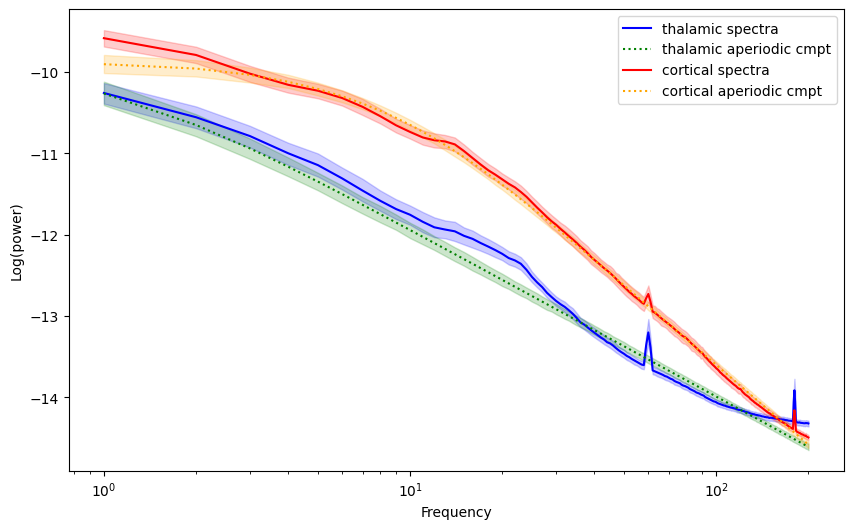

In [163]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer, x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer, x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer, x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer, x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')

# Subject Level

<Axes: xlabel='Frequency', ylabel='Log(power)'>

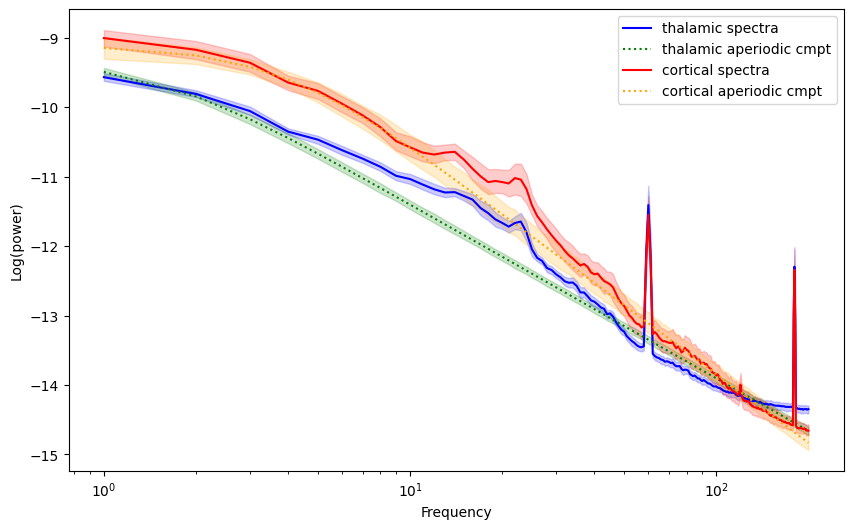

In [168]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer.query('Subject=="EM1002"'), 
             x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer.query('Subject=="EM1002"'), 
             x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer.query('Subject=="EM1002"'),
              x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer.query('Subject=="EM1002"'), 
             x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')

<Axes: xlabel='Frequency', ylabel='Log(power)'>

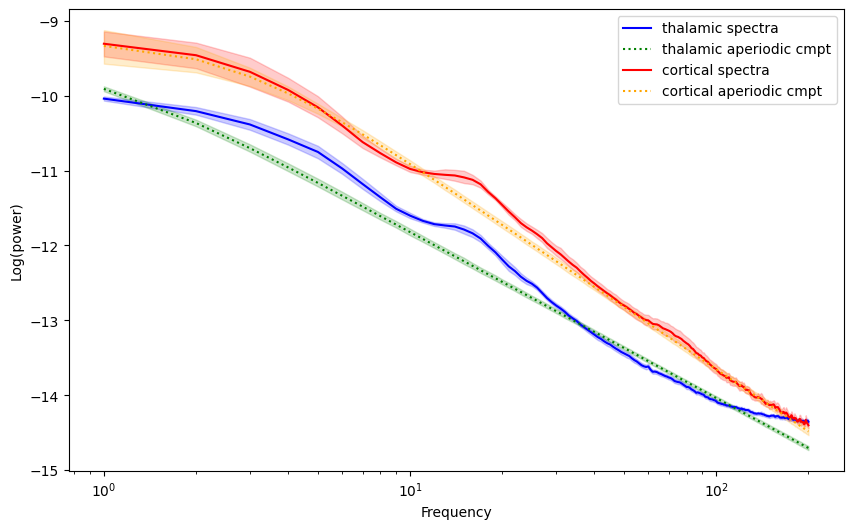

In [167]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer.query('Subject=="EM1021"'), 
             x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer.query('Subject=="EM1021"'), 
             x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer.query('Subject=="EM1021"'),
              x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer.query('Subject=="EM1021"'), 
             x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')

<Axes: xlabel='Frequency', ylabel='Log(power)'>

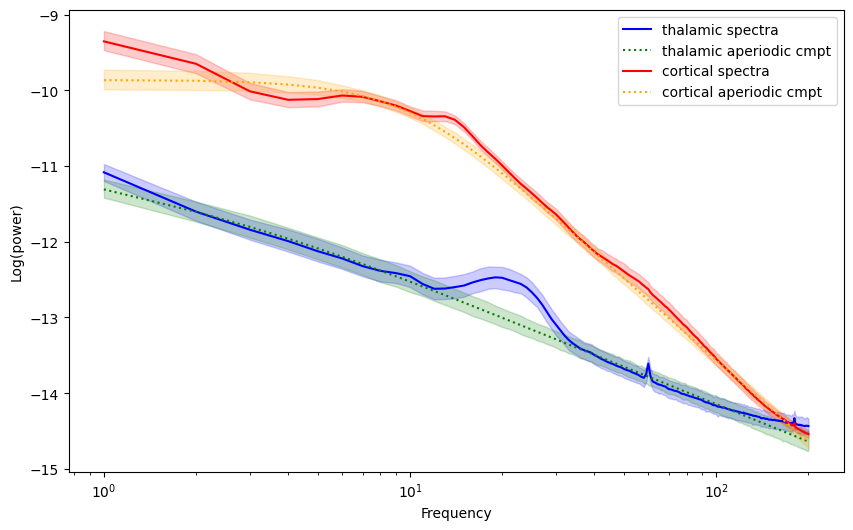

In [169]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer.query('Subject=="EM1023"'), 
             x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer.query('Subject=="EM1023"'), 
             x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer.query('Subject=="EM1023"'),
              x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer.query('Subject=="EM1023"'), 
             x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')

<Axes: xlabel='Frequency', ylabel='Log(power)'>

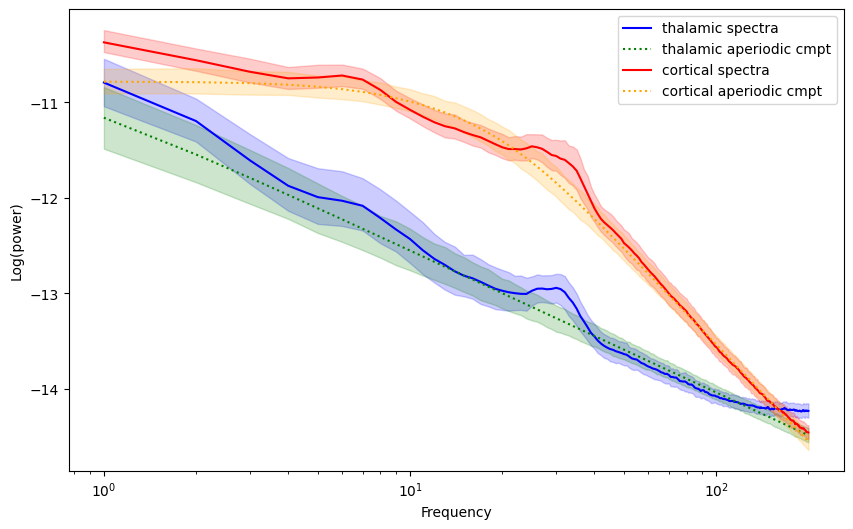

In [170]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer.query('Subject=="EM1029"'), 
             x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer.query('Subject=="EM1029"'), 
             x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer.query('Subject=="EM1029"'),
              x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer.query('Subject=="EM1029"'), 
             x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')

<Axes: xlabel='Frequency', ylabel='Log(power)'>

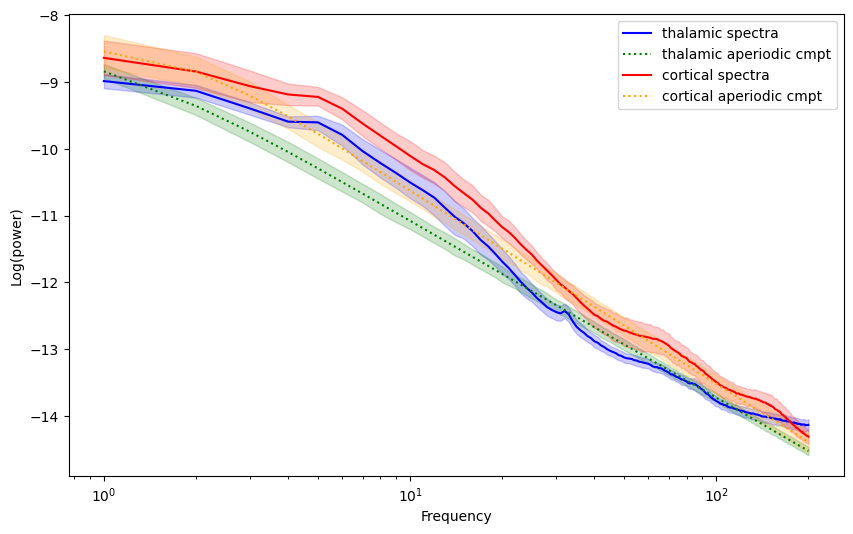

In [171]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer.query('Subject=="EM1035"'), 
             x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer.query('Subject=="EM1035"'), 
             x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer.query('Subject=="EM1035"'),
              x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer.query('Subject=="EM1035"'), 
             x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')

<Axes: xlabel='Frequency', ylabel='Log(power)'>

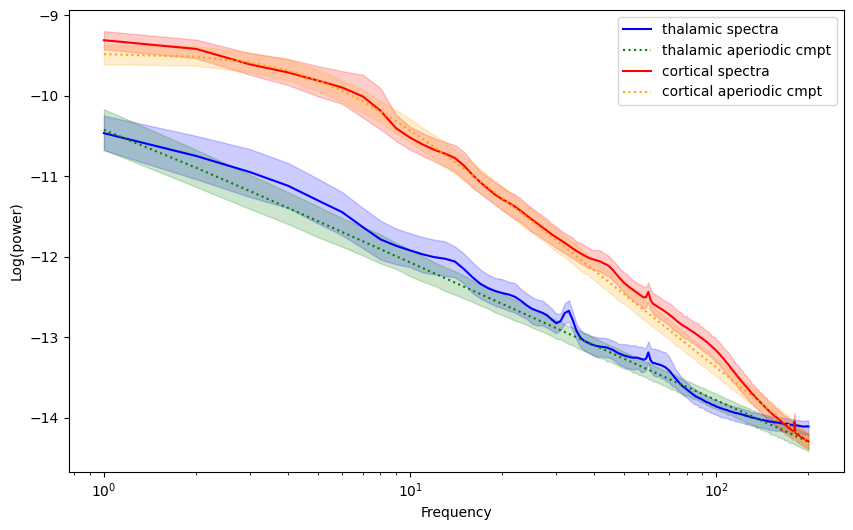

In [172]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer.query('Subject=="EM1061"'), 
             x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer.query('Subject=="EM1061"'), 
             x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer.query('Subject=="EM1061"'),
              x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer.query('Subject=="EM1061"'), 
             x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')

<Axes: xlabel='Frequency', ylabel='Log(power)'>

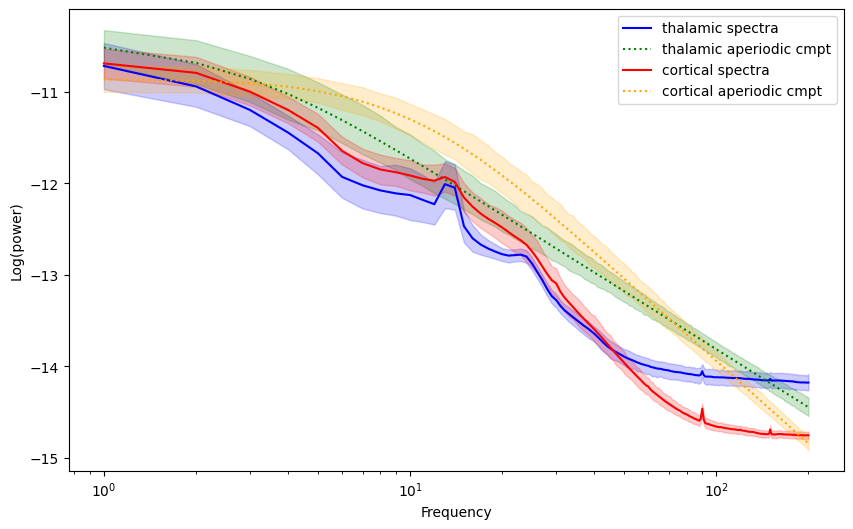

In [173]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer.query('Subject=="EM1063"'), 
             x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer.query('Subject=="EM1063"'), 
             x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer.query('Subject=="EM1063"'),
              x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer.query('Subject=="EM1063"'), 
             x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')

<Axes: xlabel='Frequency', ylabel='Log(power)'>

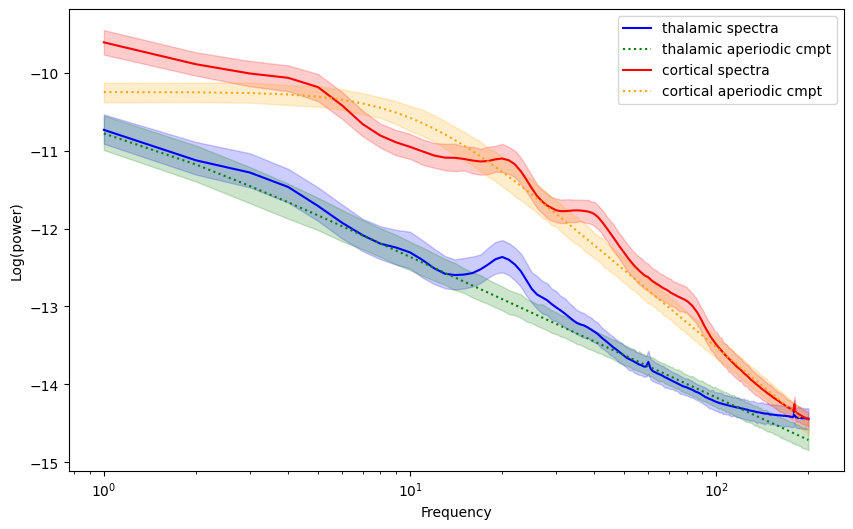

In [174]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.xscale('log')  
sns.lineplot(data=df_thalamic_spectra_longer.query('Subject=="EM1066"'), 
             x="Frequency", y="Log(power)",
             color = 'blue', linestyle = 'solid', label = 'thalamic spectra')
sns.lineplot(data=df_thalamic_ap_fit_longer.query('Subject=="EM1066"'), 
             x="Frequency", y="Log(power)",
             color = 'green', linestyle = 'dotted', label = 'thalamic aperiodic cmpt')

sns.lineplot(data=df_cortical_spectra_longer.query('Subject=="EM1066"'),
              x="Frequency", y="Log(power)",
             color = 'red', linestyle = 'solid', label = 'cortical spectra')
sns.lineplot(data=df_cortical_ap_fit_longer.query('Subject=="EM1066"'), 
             x="Frequency", y="Log(power)",
             color = 'orange', linestyle = 'dotted', label = 'cortical aperiodic cmpt')